# Customer Churn Prediction

## Importing Libraries

In [32]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
sns.set(style="whitegrid")

## Data Collection

In [33]:
df = pd.read_csv('C:/Users/kumar/OneDrive/Desktop/Machine Learning Project/datasets/customer churn analysis.csv')
df.shape

(5880, 21)

In [34]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST0000,Male,0,No,Yes,23,No,No phone service,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer,49.85,1146.55,No
1,CUST0001,Female,0,Yes,No,43,No,No phone service,DSL,Yes,...,Yes,No,Yes,No,Month-to-month,No,Mailed check,100.70,4330.10,Yes
2,CUST0002,Male,1,No,No,51,Yes,No,DSL,No,...,Yes,Yes,No,No,One year,No,Electronic check,97.33,4963.83,Yes
3,CUST0003,Male,1,No,No,72,Yes,Yes,DSL,Yes,...,Yes,No,No,No,Month-to-month,No,Credit card,101.38,7299.36,No
4,CUST0004,Male,1,No,No,25,Yes,Yes,DSL,No,...,No,Yes,No,Yes,Month-to-month,No,Electronic check,52.22,1305.50,Yes


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5880 non-null   object 
 1   gender            5880 non-null   object 
 2   SeniorCitizen     5880 non-null   int64  
 3   Partner           5880 non-null   object 
 4   Dependents        5880 non-null   object 
 5   tenure            5880 non-null   int64  
 6   PhoneService      5880 non-null   object 
 7   MultipleLines     5880 non-null   object 
 8   InternetService   5880 non-null   object 
 9   OnlineSecurity    5880 non-null   object 
 10  OnlineBackup      5880 non-null   object 
 11  DeviceProtection  5880 non-null   object 
 12  TechSupport       5880 non-null   object 
 13  StreamingTV       5880 non-null   object 
 14  StreamingMovies   5880 non-null   object 
 15  Contract          5880 non-null   object 
 16  PaperlessBilling  5880 non-null   object 


In [36]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5880.000000,5880.000000,5880.000000,5880.000000
mean,0.500680,36.549150,70.157779,2566.813165
std,0.500042,20.909674,28.804615,1910.017743
min,0.000000,1.000000,20.000000,20.030000
25%,0.000000,18.000000,45.717500,1020.217500
50%,1.000000,37.000000,70.155000,2136.445000
75%,1.000000,55.000000,95.457500,3767.665000
max,1.000000,72.000000,119.990000,8589.600000


## Data Preprocessing

In [37]:
# Quick info and missing values
print(df.info())
print('\nMissing values:\n', df.isnull().sum())
print('\nChurn distribution:\n', df['Churn'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5880 non-null   object 
 1   gender            5880 non-null   object 
 2   SeniorCitizen     5880 non-null   int64  
 3   Partner           5880 non-null   object 
 4   Dependents        5880 non-null   object 
 5   tenure            5880 non-null   int64  
 6   PhoneService      5880 non-null   object 
 7   MultipleLines     5880 non-null   object 
 8   InternetService   5880 non-null   object 
 9   OnlineSecurity    5880 non-null   object 
 10  OnlineBackup      5880 non-null   object 
 11  DeviceProtection  5880 non-null   object 
 12  TechSupport       5880 non-null   object 
 13  StreamingTV       5880 non-null   object 
 14  StreamingMovies   5880 non-null   object 
 15  Contract          5880 non-null   object 
 16  PaperlessBilling  5880 non-null   object 


In [38]:
# Preprocessing
data = df.copy()
# Convert TotalCharges to numeric (there can be spaces)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)
# Drop customerID if present
if 'customerID' in data.columns:
    data.drop('customerID', axis=1, inplace=True)
# Simplify 'No internet service' and 'No phone service' to 'No' for related columns
replace_cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines']
for c in replace_cols:
    if c in data.columns:
        data[c] = data[c].replace({'No internet service':'No','No phone service':'No'})
# Binary encode Yes/No to 1/0 for obvious columns
bin_cols = [col for col in data.columns if set(data[col].dropna().unique()).issubset({'Yes','No'})]
for c in bin_cols:
    data[c] = data[c].map({'Yes':1,'No':0})
# Map gender and other binary-like columns
if 'gender' in data.columns:
    data['gender'] = data['gender'].map({'Male':1,'Female':0})
# One-hot encode remaining categorical vars
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
print('After preprocessing shape:', data.shape)
data.head()

After preprocessing shape: (5880, 24)


C:\Windows\Temp\ipykernel_18944\3078549457.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,0,1,23,0,0,0,0,0,...,49.85,1146.55,0,False,True,False,False,False,False,False
1,0,0,1,0,43,0,0,1,0,1,...,100.70,4330.10,1,False,False,False,False,False,False,True
2,1,1,0,0,51,1,0,0,1,1,...,97.33,4963.83,1,False,False,True,False,False,True,False
3,1,1,0,0,72,1,1,1,0,1,...,101.38,7299.36,0,False,False,False,False,True,False,False
4,1,1,0,0,25,1,1,0,0,0,...,52.22,1305.50,1,False,False,False,False,False,True,False


In [39]:
# Prepare features and target
target = 'Churn'
if target not in data.columns:
    # after encoding target may still be 'Churn' as 1/0, ensure it's present
    raise ValueError('Target column not found after preprocessing')
X = data.drop(target, axis=1)
y = data[target].astype(int)
# Train/test split (stratify to keep churn ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (4704, 23) Test shape: (1176, 23)


In [40]:
# Scale numeric features
num_cols = ['tenure','MonthlyCharges','TotalCharges']
num_cols = [c for c in num_cols if c in X_train.columns]
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
# Note: scaler saving removed (no joblib files)

## Training MODEL

In [41]:
# Train a RandomForest classifier (good strong baseline for tabular data)
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
# Model saving removed (no joblib files)
print('Model trained')

Model trained


## Evaluation

In [42]:
# Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nROC AUC:', roc_auc_score(y_test, y_prob))
cm = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix:\n', cm)

Accuracy: 0.4923469387755102

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51       596
           1       0.48      0.47      0.47       580

    accuracy                           0.49      1176
   macro avg       0.49      0.49      0.49      1176
weighted avg       0.49      0.49      0.49      1176


ROC AUC: 0.49190580884054613

Confusion Matrix:
 [[309 287]
 [310 270]]


## PLots and ANalysis

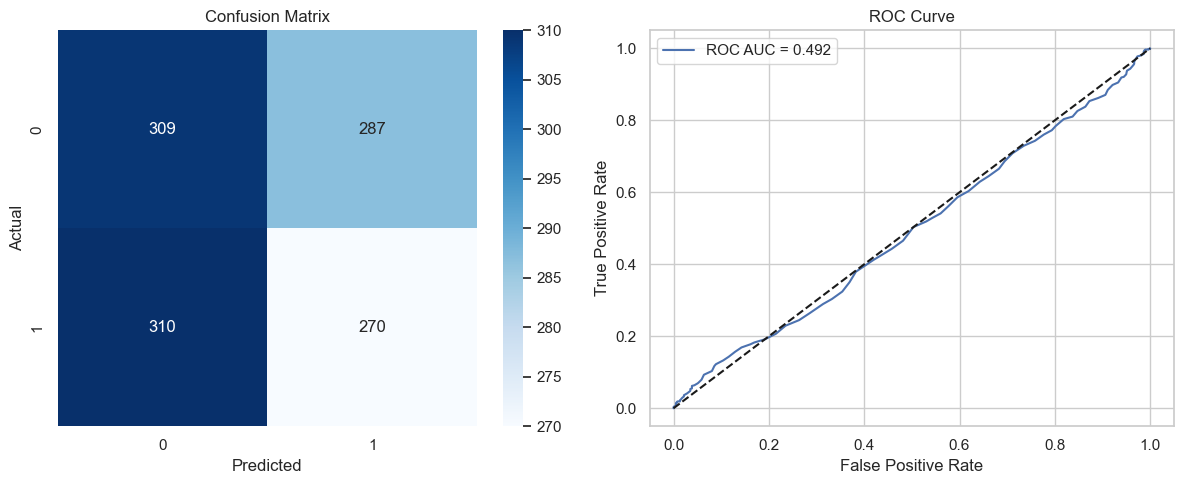

In [43]:
# Plot confusion matrix and ROC curve
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
# ROC
plt.subplot(1,2,2)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_prob):.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

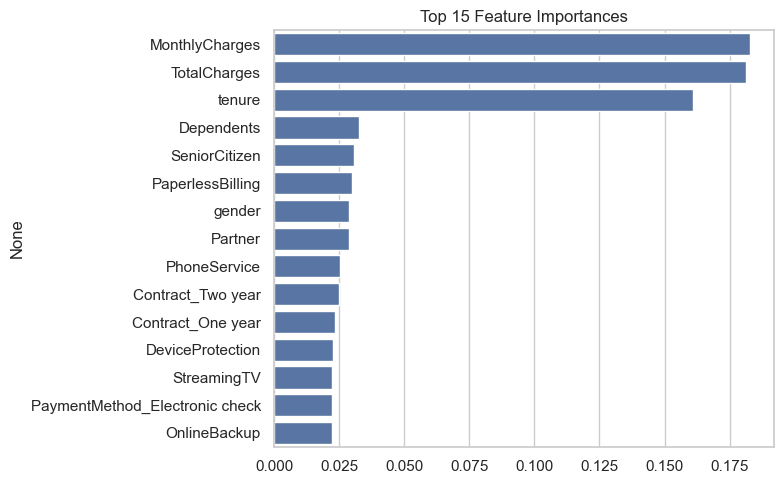

In [44]:
# Feature importances (top 15)
feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

Thanks !